# Bathymetry closeup

Get a closeup to a particular part of bathymetry file and compare with underlying gebco data.
See https://github.com/OceansAus/access-om2/issues/99

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# Eliminate margins
# from https://stackoverflow.com/questions/44298864/how-can-i-eliminate-the-gray-border-around-jupyter-ipython-notebooks-in-my-brows
from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

In [3]:
%matplotlib inline
# import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib import cm
import netCDF4 as nc
import IPython.display
import regex as re

In [4]:
# file = '/g/data3/hh5/tmp/cosima/bathymetry/topog_latest.nc'

# see https://github.com/OceansAus/access-om2/issues/99
fixedbathyfile = '/g/data3/hh5/tmp/cosima/bathymetry/topog_13_06_2018.baffin.nc'

depth = nc.Dataset(fixedbathyfile).variables['depth'][:,:]

file2 = '/g/data3/hh5/tmp/cosima/bathymetry/ocean_hgrid.nc'
data2 = nc.Dataset(file2)
lons = data2.variables['x'][::2,::2]
lats = data2.variables['y'][::2,::2]

`ncdump -h /short/v45/aek156/access-om2/control/01deg_jra55_iaf/work/ocean/rregionocean_daily_30m.nc.3829`
yields
```
		xt_ocean_sub01:domain_decomposition = 1, 3600, 3331, 3375 ;
		yt_ocean_sub01:domain_decomposition = 1, 2700, 2377, 2412 ;
```

In [5]:
# location of region of interest as reported by MOM (-1 to index from 0)

imin = 3331-1
imax = 3375-1
jmin = 2377-1
jmax = 2412-1

i = (imax + imin)/2
j = (jmax + jmin)/2

<Figure size 720x720 with 0 Axes>

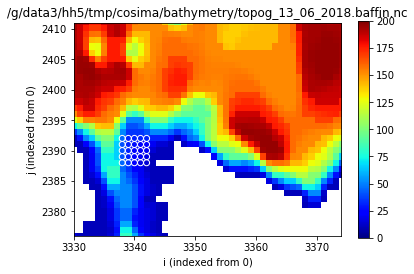

In [22]:
# from ocean/field_table
damp_table='''
"rayleigh_damp_table","ocean_mod","rayleigh_damp_table"
"rayleigh","KaraStr","itable=3339,jtable=2389,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3340,jtable=2389,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3341,jtable=2389,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3342,jtable=2389,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3343,jtable=2389,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3339,jtable=2390,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3340,jtable=2390,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3341,jtable=2390,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3342,jtable=2390,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3343,jtable=2390,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3339,jtable=2391,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3340,jtable=2391,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3341,jtable=2391,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3342,jtable=2391,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3343,jtable=2391,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3339,jtable=2392,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3340,jtable=2392,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3341,jtable=2392,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3342,jtable=2392,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3343,jtable=2392,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3339,jtable=2393,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3340,jtable=2393,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3341,jtable=2393,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3342,jtable=2393,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3343,jtable=2393,ktable_1=1,ktable_2=75,rayleigh_damp_table=86400"
'''

# subtract 1 to index from 0
ii = [ int(i)-1 for i in re.findall('itable=(\d+)', damp_table) ]
jj = [ int(j)-1 for j in re.findall('jtable=(\d+)', damp_table) ]

plt.figure(figsize=(10,10))
fig,ax = plt.subplots()
plt.imshow(depth, vmin=0, vmax=200, origin='lower', cmap=plt.cm.jet)
plt.colorbar(ax=ax)
plt.scatter(ii,jj, facecolors='none', edgecolors='w')
plt.xlim(imin,imax)
plt.ylim(jmin,jmax)
plt.title(fixedbathyfile)
plt.xlabel('i (indexed from 0)')
plt.ylabel('j (indexed from 0)');

<Figure size 720x720 with 0 Axes>

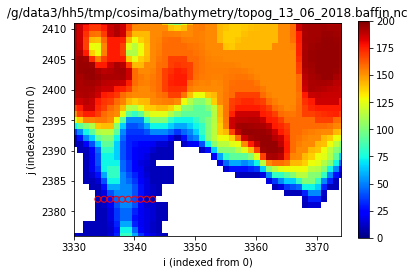

In [28]:
# from ocean/field_table
damp_table='''
"rayleigh_damp_table","ocean_mod","rayleigh_damp_table"
"rayleigh","KaraStr","itable=3335,jtable=2383,ktable_1=1,ktable_2=22,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3336,jtable=2383,ktable_1=1,ktable_2=22,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3337,jtable=2383,ktable_1=1,ktable_2=22,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3338,jtable=2383,ktable_1=1,ktable_2=22,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3339,jtable=2383,ktable_1=1,ktable_2=22,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3340,jtable=2383,ktable_1=1,ktable_2=22,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3341,jtable=2383,ktable_1=1,ktable_2=22,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3342,jtable=2383,ktable_1=1,ktable_2=22,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3343,jtable=2383,ktable_1=1,ktable_2=22,rayleigh_damp_table=86400"
"rayleigh","KaraStr","itable=3344,jtable=2383,ktable_1=1,ktable_2=22,rayleigh_damp_table=86400"
/
'''

# subtract 1 to index from 0
ii = [ int(i)-1 for i in re.findall('itable=(\d+)', damp_table) ]
jj = [ int(j)-1 for j in re.findall('jtable=(\d+)', damp_table) ]

plt.figure(figsize=(10,10))
fig,ax = plt.subplots()
plt.imshow(depth, vmin=0, vmax=200, origin='lower', cmap=plt.cm.jet)
plt.colorbar(ax=ax)
plt.scatter(ii,jj, facecolors='none', edgecolors='r')
plt.xlim(imin,imax)
plt.ylim(jmin,jmax)
plt.title(fixedbathyfile)
plt.xlabel('i (indexed from 0)')
plt.ylabel('j (indexed from 0)');

<Figure size 720x720 with 0 Axes>

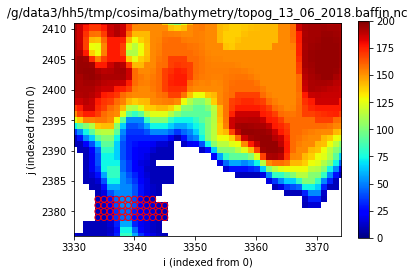

In [6]:
# from ocean/field_table
damp_table='''
"rayleigh","KaraStr","itable=3335,jtable=2380,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3336,jtable=2380,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3337,jtable=2380,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3338,jtable=2380,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3339,jtable=2380,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3340,jtable=2380,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3341,jtable=2380,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3342,jtable=2380,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3343,jtable=2380,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3344,jtable=2380,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3345,jtable=2380,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3346,jtable=2380,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3335,jtable=2381,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3336,jtable=2381,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3337,jtable=2381,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3338,jtable=2381,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3339,jtable=2381,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3340,jtable=2381,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3341,jtable=2381,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3342,jtable=2381,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3343,jtable=2381,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3344,jtable=2381,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3345,jtable=2381,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3346,jtable=2381,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3335,jtable=2382,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3336,jtable=2382,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3337,jtable=2382,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3338,jtable=2382,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3339,jtable=2382,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3340,jtable=2382,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3341,jtable=2382,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3342,jtable=2382,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3343,jtable=2382,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3344,jtable=2382,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3345,jtable=2382,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3346,jtable=2382,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3335,jtable=2383,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3336,jtable=2383,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3337,jtable=2383,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3338,jtable=2383,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3339,jtable=2383,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3340,jtable=2383,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3341,jtable=2383,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3342,jtable=2383,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3343,jtable=2383,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
"rayleigh","KaraStr","itable=3344,jtable=2383,ktable_1=1,ktable_2=22,rayleigh_damp_table=5400"
'''

# subtract 1 to index from 0
ii = [ int(i)-1 for i in re.findall('itable=(\d+)', damp_table) ]
jj = [ int(j)-1 for j in re.findall('jtable=(\d+)', damp_table) ]

plt.figure(figsize=(10,10))
fig,ax = plt.subplots()
plt.imshow(depth, vmin=0, vmax=200, origin='lower', cmap=plt.cm.jet)
plt.colorbar(ax=ax)
plt.scatter(ii,jj, facecolors='none', edgecolors='r')
plt.xlim(imin,imax)
plt.ylim(jmin,jmax)
plt.title(fixedbathyfile)
plt.xlabel('i (indexed from 0)')
plt.ylabel('j (indexed from 0)');